Если прочитать описание данных, можно увидеть следующее: 
<br><b>shift</b> - на сколько недель значения признаков отстают от недели, записанной в week (отставание признаков нужно чтобы научиться прогнозировать продажи на 2 или 3 недели вперед)
<br> Действительно направгивается какое-то преобразование датасета, так как в данный момент, если посмотреть на датасет train, видно, что у нас одинаковые целевые переменные, например 110776, разные shift, и абсолютно разный набор f-ок. 
<br>Довольно странно ожидать хорошего качества регрессии, если у нас при абсолютно разных наборах X одинаковые значения y.
<br>Можно сдвинуть признаки к соответствующим неделям, чтобы не было запоздания, но это получится сделать не у всех, их мы в данный момент просто выкинем. В тестовом датасете получится сделать такой сдвиг у 2/3 записей, я обучал отдельно модель1 для записей со сдвигом (2/3) (конечно же на преобразованном датасете) и отдельно модель2 для предсказания записей без сдвига (1/3).
Я не очень заморачивался с подбором параметром, возможно, при хорошем переборе, можно добиться улучшения на 0.5-1.0 по метрике smape.
Мой финальный результат 9.7130.

In [64]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso
from collections import Counter
import xgboost
import matplotlib.pyplot as plt
from sklearn import cross_validation, grid_search
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [65]:
train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")

In [66]:
test.head()

,Num,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
0,348622,2015,3,3,20447918,960.0,820.0,1128.0,1801.0,1045.0,...,1510.0,580.0,969.0,1635.0,895.0,2140.0,1182.0,1020.0,1293.0,1290.0
1,348623,2015,3,3,20447902,9086.0,12585.0,11595.0,9685.0,12917.0,...,22055.0,14235.0,21195.0,18280.0,18270.0,15851.0,16920.0,18320.0,24116.0,21307.0
2,348624,2015,3,3,20447732,115087.0,147287.0,176065.0,143105.0,202069.0,...,302165.0,162232.0,221622.0,256605.0,240047.0,236630.0,206697.0,245652.0,286179.0,285904.0
3,348625,2015,3,3,20443951,20900.0,24420.0,27068.0,20460.0,25580.0,...,39055.0,14445.0,22450.0,22093.0,31175.0,23355.0,15358.0,18930.0,29643.0,33970.0
4,348626,2015,3,3,20443944,4430.0,5864.0,3310.0,1853.0,2836.0,...,120.0,130.0,60.0,30.0,50.0,20.0,20.0,30.0,0.0,0.0


In [67]:
train.head()

,Num,y,year,week,shift,item_id,f1,f2,f3,f4,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
0,0,123438,2012,52,1,20442076,4915.0,38056.0,40185.0,45733.0,...,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0
1,1,58410,2012,52,1,20441997,2230.0,18817.0,20110.0,26368.0,...,22830.0,25230.0,27850.0,21390.0,27090.0,23170.0,29705.0,19140.0,22055.0,23200.0
2,2,163930,2012,52,1,20441990,5695.0,47480.0,47619.0,89708.0,...,14930.0,44290.0,46412.0,29320.0,21140.0,28406.0,65056.0,31886.0,48750.0,36520.0
3,3,53902,2012,52,1,20441989,1995.0,17146.0,20066.0,27070.0,...,15120.0,12480.0,19780.0,7990.0,8230.0,10650.0,21920.0,13040.0,9780.0,9630.0
4,4,105970,2012,52,1,20441988,6515.0,49262.0,50045.0,95167.0,...,18872.0,19328.0,37168.0,13570.0,19760.0,20208.0,34745.0,18442.0,24700.0,21793.0


In [68]:
def smape(y_pred, y_true):
    return (100 / y_pred.shape[0]) * np.sum(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true)) / 2))

Давайте посмотрим на забавную матрицу корреляций признаков

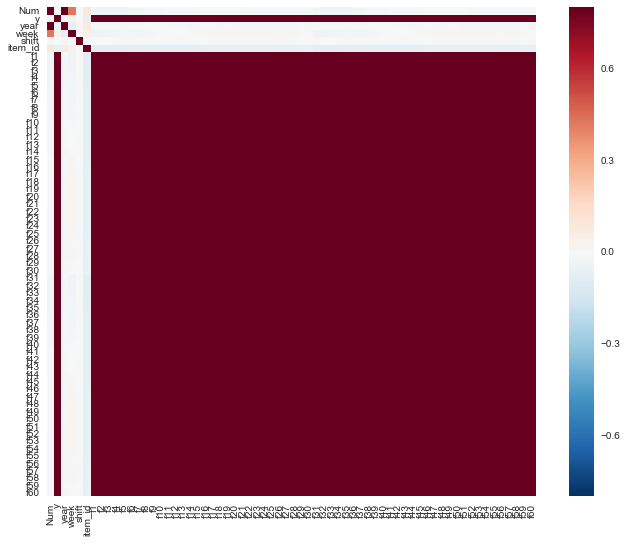

In [69]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

Также стоит зметить, что признаки f1 и f31 полностью совпадают, f2 и f32 и тд., нет смысла включать их в модель

In [70]:
print (np.array(train["f1"]))
print (np.array(train["f31"]))
print (np.array(train["f2"]))
print (np.array(train["f32"]))
res = 0
for i in range(1, 31):
    if (np.sum(np.array(train["f"+str(i)]) == np.array(train["f"+str(i+30)])) == train.shape[0]):
        res += 1
print(res)

[ 4915.  2230.  5695. ...,   515.  5597.    10.]
[ 4915.  2230.  5695. ...,   515.  5597.    10.]
[ 38056.  18817.  47480. ...,    795.   5595.      0.]
[ 38056.  18817.  47480. ...,    795.   5595.      0.]
30


In [71]:
for i in range(31, 61):
    del train["f" + str(i)]
    del test["f" + str(i)]

In [72]:
print (train.shape)
train.head()

(72457, 36)


,Num,y,year,week,shift,item_id,f1,f2,f3,f4,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,0,123438,2012,52,1,20442076,4915.0,38056.0,40185.0,45733.0,...,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0
1,1,58410,2012,52,1,20441997,2230.0,18817.0,20110.0,26368.0,...,22830.0,25230.0,27850.0,21390.0,27090.0,23170.0,29705.0,19140.0,22055.0,23200.0
2,2,163930,2012,52,1,20441990,5695.0,47480.0,47619.0,89708.0,...,14930.0,44290.0,46412.0,29320.0,21140.0,28406.0,65056.0,31886.0,48750.0,36520.0
3,3,53902,2012,52,1,20441989,1995.0,17146.0,20066.0,27070.0,...,15120.0,12480.0,19780.0,7990.0,8230.0,10650.0,21920.0,13040.0,9780.0,9630.0
4,4,105970,2012,52,1,20441988,6515.0,49262.0,50045.0,95167.0,...,18872.0,19328.0,37168.0,13570.0,19760.0,20208.0,34745.0,18442.0,24700.0,21793.0


In [73]:
print (test.shape)
test.head()

(2016, 35)


,Num,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,348622,2015,3,3,20447918,960.0,820.0,1128.0,1801.0,1045.0,...,1510.0,580.0,969.0,1635.0,895.0,2140.0,1182.0,1020.0,1293.0,1290.0
1,348623,2015,3,3,20447902,9086.0,12585.0,11595.0,9685.0,12917.0,...,22055.0,14235.0,21195.0,18280.0,18270.0,15851.0,16920.0,18320.0,24116.0,21307.0
2,348624,2015,3,3,20447732,115087.0,147287.0,176065.0,143105.0,202069.0,...,302165.0,162232.0,221622.0,256605.0,240047.0,236630.0,206697.0,245652.0,286179.0,285904.0
3,348625,2015,3,3,20443951,20900.0,24420.0,27068.0,20460.0,25580.0,...,39055.0,14445.0,22450.0,22093.0,31175.0,23355.0,15358.0,18930.0,29643.0,33970.0
4,348626,2015,3,3,20443944,4430.0,5864.0,3310.0,1853.0,2836.0,...,120.0,130.0,60.0,30.0,50.0,20.0,20.0,30.0,0.0,0.0


### Я уже знаю, что ждёт нас дальше, так что давайте просто обучим RandomForest на неизменённом датасете (именно он показал самое хорошое качество из первых 3 посылок)

In [99]:
model_1 = RandomForestRegressor(n_estimators=350, min_samples_leaf=7, min_samples_split=2)

In [100]:
train1 = train.head(45000)
train2 = train.tail(train.shape[0]-45000)

In [101]:
X1 = train1.drop(['Num','y'], axis=1)
y1 = train1['y']
X2 = train2.drop(['Num','y'], axis=1)
y2 = train2['y']
y1 = np.array(y1)
y2 = np.array(y2)

In [102]:
%%time
model_1.fit(X1, y1)

CPU times: user 5min 24s, sys: 1.99 s, total: 5min 26s
Wall time: 5min 29s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=7,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=350, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [103]:
res = model_1.predict(X2)
smape(res, y2)

27.00870350764599

In [104]:
train = train.sort(['item_id', 'year', 'week', 'shift'])
print (train.shape)

(72457, 36)


In [105]:
del train['Num']

In [106]:
converted_train = train

Посмотрим, сколько недель в 2013 и 2014 годах, это нам поможет при изменении датасета

In [107]:
converted_train[converted_train["year"] == 2013].tail(5)

,y,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
34531,223657,2013,51,2,20453563,229136.0,237506.0,295042.0,210294.0,132000.0,...,270833.0,101837.0,116481.0,117941.0,212682.0,54410.0,116162.0,108257.0,207430.0,96811.0
34086,223657,2013,51,3,20453563,180591.0,229136.0,237506.0,295042.0,210294.0,...,167200.0,270833.0,101837.0,116481.0,117941.0,212682.0,54410.0,116162.0,108257.0,207430.0
35655,329673,2013,52,1,20453563,295042.0,210294.0,132000.0,237890.0,218525.0,...,116481.0,117941.0,212682.0,54410.0,116162.0,108257.0,207430.0,96811.0,95152.0,138918.0
35205,329673,2013,52,2,20453563,237506.0,295042.0,210294.0,132000.0,237890.0,...,101837.0,116481.0,117941.0,212682.0,54410.0,116162.0,108257.0,207430.0,96811.0,95152.0
34756,329673,2013,52,3,20453563,229136.0,237506.0,295042.0,210294.0,132000.0,...,270833.0,101837.0,116481.0,117941.0,212682.0,54410.0,116162.0,108257.0,207430.0,96811.0


In [108]:
converted_train[converted_train["year"] == 2014].tail(5)

,y,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
70077,171081,2014,52,2,20453563,125906.0,151188.0,120173.0,103150.0,128910.0,...,68340.0,66660.0,76850.0,107219.0,55220.0,83429.0,80070.0,68716.0,67745.0,74174.0
69625,171081,2014,52,3,20453563,112293.0,125906.0,151188.0,120173.0,103150.0,...,155135.0,68340.0,66660.0,76850.0,107219.0,55220.0,83429.0,80070.0,68716.0,67745.0
71197,168919,2014,53,1,20453563,120173.0,103150.0,128910.0,119210.0,118701.0,...,76850.0,107219.0,55220.0,83429.0,80070.0,68716.0,67745.0,74174.0,81926.0,106262.0
70751,168919,2014,53,2,20453563,151188.0,120173.0,103150.0,128910.0,119210.0,...,66660.0,76850.0,107219.0,55220.0,83429.0,80070.0,68716.0,67745.0,74174.0,81926.0
70302,168919,2014,53,3,20453563,125906.0,151188.0,120173.0,103150.0,128910.0,...,68340.0,66660.0,76850.0,107219.0,55220.0,83429.0,80070.0,68716.0,67745.0,74174.0


In [109]:
converted_train_m = converted_train.as_matrix()
print (converted_train_m.shape)
converted_train_m 

(72457, 35)


array([[  3.40138000e+05,   2.01200000e+03,   5.20000000e+01, ...,
          8.87890000e+04,   1.08817000e+05,   1.10228000e+05],
       [  1.10776000e+05,   2.01300000e+03,   1.00000000e+00, ...,
          1.08817000e+05,   1.10228000e+05,   2.11266000e+05],
       [  1.10776000e+05,   2.01300000e+03,   1.00000000e+00, ...,
          8.87890000e+04,   1.08817000e+05,   1.10228000e+05],
       ..., 
       [  1.26618000e+05,   2.01500000e+03,   2.00000000e+00, ...,
          1.06262000e+05,   1.04919000e+05,   1.83820000e+04],
       [  1.26618000e+05,   2.01500000e+03,   2.00000000e+00, ...,
          8.19260000e+04,   1.06262000e+05,   1.04919000e+05],
       [  1.26618000e+05,   2.01500000e+03,   2.00000000e+00, ...,
          7.41740000e+04,   8.19260000e+04,   1.06262000e+05]])

In [110]:
modified = np.zeros(converted_train_m.shape[0])

In [111]:
train.head()

,y,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
150,340138,2012,52,1,20427028,9700.0,92038.0,111363.0,146522.0,174408.0,...,93799.0,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0
841,110776,2013,1,1,20427028,92038.0,111363.0,146522.0,174408.0,111337.0,...,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0
380,110776,2013,1,2,20427028,9700.0,92038.0,111363.0,146522.0,174408.0,...,93799.0,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0
1536,70915,2013,2,1,20427028,111363.0,146522.0,174408.0,111337.0,124149.0,...,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0
1072,70915,2013,2,2,20427028,92038.0,111363.0,146522.0,174408.0,111337.0,...,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0


In [112]:
year_pos = 1
week_pos = 2
shift_pos = 3
item_pos = 4
for i in tqdm(range(converted_train_m.shape[0])):
    year1 = converted_train_m[i][year_pos]
    week1 = converted_train_m[i][week_pos]
    shift1 = converted_train_m[i][shift_pos]
    item1 = converted_train_m[i][item_pos]
    week2 = week1 - shift1
    year2 = year1
    #if (i == 6):
    #    print (week1, year1, item1, shift1)
    if (week2 <= 0):
        if (year1 == 2014):
            week2 = 52 - week1
        if (year2 == 2015):
            week2 = 53 - week1
        year2 = year1 - 1
    for j in range(i, 0, -1):
        #if (i == 6):
        #    print (j, ": ", converted_train_m[j][year_pos], converted_train_m[j][week_pos], converted_train_m[j][item_pos])
        if (converted_train_m[j][year_pos] == year2 and converted_train_m[j][week_pos] == week2 and 
            converted_train_m[j][item_pos] == item1 and converted_train_m[j][shift_pos] == shift1):
            if (modified[j] == 0):
                converted_train_m[j][5:35] = converted_train_m[i][5:35]
                modified[j] = 1
            break

100%|██████████| 72457/72457 [00:59<00:00, 1220.96it/s]


In [113]:
print (len(modified))
print (np.sum(modified))

72457
68763.0


In [114]:
corrected_train_m = converted_train_m

In [115]:
cols = train.columns
cols

Index(['y', 'year', 'week', 'shift', 'item_id', 'f1', 'f2', 'f3', 'f4', 'f5',
       'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16',
       'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26',
       'f27', 'f28', 'f29', 'f30'],
      dtype='object')

In [116]:
new_dataset_train = pd.DataFrame(converted_train_m, columns=cols)

In [117]:
new_dataset_train.head()

,y,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,340138.0,2012.0,52.0,1.0,20427028.0,9700.0,92038.0,111363.0,146522.0,174408.0,...,93799.0,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0
1,110776.0,2013.0,1.0,1.0,20427028.0,111363.0,146522.0,174408.0,111337.0,124149.0,...,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0
2,110776.0,2013.0,1.0,2.0,20427028.0,111363.0,146522.0,174408.0,111337.0,124149.0,...,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0
3,70915.0,2013.0,2.0,1.0,20427028.0,146522.0,174408.0,111337.0,124149.0,119286.0,...,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0,44047.0
4,70915.0,2013.0,2.0,2.0,20427028.0,146522.0,174408.0,111337.0,124149.0,119286.0,...,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0,44047.0


In [118]:
new_dataset_train["modi"] = modified
new_dataset_train.head()

,y,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f22,f23,f24,f25,f26,f27,f28,f29,f30,modi
0,340138.0,2012.0,52.0,1.0,20427028.0,9700.0,92038.0,111363.0,146522.0,174408.0,...,113945.0,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,0.0
1,110776.0,2013.0,1.0,1.0,20427028.0,111363.0,146522.0,174408.0,111337.0,124149.0,...,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0,1.0
2,110776.0,2013.0,1.0,2.0,20427028.0,111363.0,146522.0,174408.0,111337.0,124149.0,...,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0,1.0
3,70915.0,2013.0,2.0,1.0,20427028.0,146522.0,174408.0,111337.0,124149.0,119286.0,...,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0,44047.0,1.0
4,70915.0,2013.0,2.0,2.0,20427028.0,146522.0,174408.0,111337.0,124149.0,119286.0,...,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0,44047.0,1.0


In [119]:
new_dataset_train = new_dataset_train[new_dataset_train["modi"] == 1]
del new_dataset_train['modi']
new_dataset_train.head()

,y,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
1,110776.0,2013.0,1.0,1.0,20427028.0,111363.0,146522.0,174408.0,111337.0,124149.0,...,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0
2,110776.0,2013.0,1.0,2.0,20427028.0,111363.0,146522.0,174408.0,111337.0,124149.0,...,156656.0,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0
3,70915.0,2013.0,2.0,1.0,20427028.0,146522.0,174408.0,111337.0,124149.0,119286.0,...,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0,44047.0
4,70915.0,2013.0,2.0,2.0,20427028.0,146522.0,174408.0,111337.0,124149.0,119286.0,...,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0,44047.0
5,70915.0,2013.0,2.0,3.0,20427028.0,146522.0,174408.0,111337.0,124149.0,119286.0,...,69913.0,96291.0,112953.0,164259.0,88789.0,108817.0,110228.0,211266.0,68805.0,44047.0


### Теперь поработаем с тестовым датасетом

In [120]:
print (test.shape)
test.sort(['item_id', 'year', 'week', 'shift']).head()

(2016, 35)


,Num,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
822,350335,2015,3,1,20427028,112386.0,103264.0,98742.0,108584.0,102320.0,...,95788.0,81425.0,105634.0,96496.0,82307.0,88269.0,126779.0,124853.0,21081.0,75404.0
370,349663,2015,3,2,20427028,107536.0,112386.0,103264.0,98742.0,108584.0,...,61980.0,95788.0,81425.0,105634.0,96496.0,82307.0,88269.0,126779.0,124853.0,21081.0
144,348766,2015,3,3,20427028,92012.0,107536.0,112386.0,103264.0,98742.0,...,126866.0,61980.0,95788.0,81425.0,105634.0,96496.0,82307.0,88269.0,126779.0,124853.0
1496,351009,2015,4,1,20427028,103264.0,98742.0,108584.0,102320.0,122395.0,...,81425.0,105634.0,96496.0,82307.0,88269.0,126779.0,124853.0,21081.0,75404.0,83046.0
1050,350563,2015,4,2,20427028,112386.0,103264.0,98742.0,108584.0,102320.0,...,95788.0,81425.0,105634.0,96496.0,82307.0,88269.0,126779.0,124853.0,21081.0,75404.0


In [121]:
test_m = test.as_matrix()
print (test_m.shape)
test_m 

(2016, 35)


array([[  3.48622000e+05,   2.01500000e+03,   3.00000000e+00, ...,
          1.02000000e+03,   1.29300000e+03,   1.29000000e+03],
       [  3.48623000e+05,   2.01500000e+03,   3.00000000e+00, ...,
          1.83200000e+04,   2.41160000e+04,   2.13070000e+04],
       [  3.48624000e+05,   2.01500000e+03,   3.00000000e+00, ...,
          2.45652000e+05,   2.86179000e+05,   2.85904000e+05],
       ..., 
       [  3.51526000e+05,   2.01500000e+03,   5.00000000e+00, ...,
          1.13270000e+04,   1.07320000e+04,   1.57090000e+04],
       [  3.51527000e+05,   2.01500000e+03,   5.00000000e+00, ...,
          3.37000000e+02,   1.95000000e+02,   2.00000000e+02],
       [  3.51528000e+05,   2.01500000e+03,   5.00000000e+00, ...,
          2.59700000e+03,   3.98100000e+03,   4.48900000e+03]])

In [122]:
modified = np.zeros(test_m.shape[0])

In [123]:
year_pos = 1
week_pos = 2
shift_pos = 3
item_pos = 4
for i in tqdm(range(test_m.shape[0])):
    year1 = test_m[i][year_pos]
    week1 = test_m[i][week_pos]
    shift1 = test_m[i][shift_pos]
    item1 = test_m[i][item_pos]
    week2 = week1 - shift1
    year2 = year1
    #if (i == 3):
    #    print (week1, year1, item1, shift1)
    if (week2 <= 0):
        if (year1 == 2014):
            week2 = 52 - week1
        if (year2 == 2015):
            week2 = 53 - week1
        year2 = year1 - 1
    for j in range(0, test_m.shape[0]):
        #if (i == 3):
        #    print (j, ": ", test_m[j][year_pos], test_m[j][week_pos], test_m[j][item_pos])
        if (test_m[j][year_pos] == year2 and test_m[j][week_pos] == week2 and 
            test_m[j][item_pos] == item1):
            if (modified[j] == 0):
                test_m[j][5:65] = test_m[i][5:65]
                modified[j] = 1

100%|██████████| 2016/2016 [00:03<00:00, 518.10it/s]


In [124]:
test_m

array([[  3.48622000e+05,   2.01500000e+03,   3.00000000e+00, ...,
          4.22000000e+02,   1.69000000e+03,   9.30000000e+02],
       [  3.48623000e+05,   2.01500000e+03,   3.00000000e+00, ...,
          6.66100000e+03,   2.06100000e+04,   1.67910000e+04],
       [  3.48624000e+05,   2.01500000e+03,   3.00000000e+00, ...,
          5.48460000e+04,   1.71320000e+05,   1.84820000e+05],
       ..., 
       [  3.51526000e+05,   2.01500000e+03,   5.00000000e+00, ...,
          1.13270000e+04,   1.07320000e+04,   1.57090000e+04],
       [  3.51527000e+05,   2.01500000e+03,   5.00000000e+00, ...,
          3.37000000e+02,   1.95000000e+02,   2.00000000e+02],
       [  3.51528000e+05,   2.01500000e+03,   5.00000000e+00, ...,
          2.59700000e+03,   3.98100000e+03,   4.48900000e+03]])

In [125]:
print (len(modified))
print (np.sum(modified))

2016
1335.0


Видим, что около 2/3 мы смогли преобразовать, как мы делали это в train, но для последней недели нет следующей, из которой мы бы могли взять информацию

In [126]:
cols = test.columns
cols

Index(['Num', 'year', 'week', 'shift', 'item_id', 'f1', 'f2', 'f3', 'f4', 'f5',
       'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16',
       'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26',
       'f27', 'f28', 'f29', 'f30'],
      dtype='object')

In [127]:
new_dataset_test = pd.DataFrame(test_m, columns=cols)

In [128]:
new_dataset_test["modi"] = modified

In [129]:
new_dataset_test.head()

,Num,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f22,f23,f24,f25,f26,f27,f28,f29,f30,modi
0,348622.0,2015.0,3.0,3.0,20447918.0,1801.0,1045.0,1190.0,1310.0,1111.0,...,895.0,2140.0,1182.0,1020.0,1293.0,1290.0,422.0,1690.0,930.0,1.0
1,348623.0,2015.0,3.0,3.0,20447902.0,9685.0,12917.0,11157.0,12105.0,11765.0,...,18270.0,15851.0,16920.0,18320.0,24116.0,21307.0,6661.0,20610.0,16791.0,1.0
2,348624.0,2015.0,3.0,3.0,20447732.0,143105.0,202069.0,216920.0,236053.0,257198.0,...,240047.0,236630.0,206697.0,245652.0,286179.0,285904.0,54846.0,171320.0,184820.0,1.0
3,348625.0,2015.0,3.0,3.0,20443951.0,20460.0,25580.0,27135.0,24059.0,27335.0,...,31175.0,23355.0,15358.0,18930.0,29643.0,33970.0,7787.0,20395.0,18305.0,1.0
4,348626.0,2015.0,3.0,3.0,20443944.0,1853.0,2836.0,2807.0,2550.0,3951.0,...,50.0,20.0,20.0,30.0,0.0,0.0,0.0,10.0,10.0,1.0


Мы уже обучили в самом начале ноутбука модель под неизменённый датасет, и теперь необходимо обучить модель на изменённый, в тестовой выборке будем предсказывать целевую переменную для неизменённых строк с помощью первой модели, а для изменённых с помощью второй

In [130]:
model_2 = RandomForestRegressor(n_estimators=100, min_samples_leaf=4, min_samples_split=2)

In [131]:
new_dataset_train.shape

(68763, 35)

In [132]:
X1 = new_dataset_train.head(45000).drop(['y'], axis=1)
y1 = new_dataset_train.head(45000)['y']
X2 = new_dataset_train.tail(23000).drop(['y'], axis=1)
y2 = new_dataset_train.tail(23000)['y']
y1 = np.array(y1)
y2 = np.array(y2)

In [133]:
%%time
model_2.fit(X1, y1)

CPU times: user 1min 16s, sys: 518 ms, total: 1min 17s
Wall time: 1min 18s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [134]:
res = model_2.predict(X2)
smape(res,y2)

0.8860961165977862

In [54]:
%%time
results = []
for n_e in [10, 20, 40]:
    for m_s_l in [1, 3, 5]:
        for m_s_s in [2, 3]:
            tmp = []
            for i in range(5):
                trainnnnn = shuffle(new_dataset_train)
                train1 = trainnnnn.head(45000)
                train2 = trainnnnn.tail(train.shape[0]-45000)
                X1 = train1.drop(['y'], axis=1)
                y1 = train1['y']
                X2 = train2.drop(['y'], axis=1)
                y2 = train2['y']
                y1 = np.array(y1)
                y2 = np.array(y2)
                model = RandomForestRegressor(n_estimators=n_e, min_samples_leaf=m_s_l, min_samples_split=m_s_s)
                model.fit(X1, y1)
                res = model.predict(X2)
                tmp.append(smape(res, y2))
            results.append((np.mean(tmp), n_e, m_s_l, m_s_s))

KeyboardInterrupt: 

In [135]:
new_dataset_test.head()

,Num,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f22,f23,f24,f25,f26,f27,f28,f29,f30,modi
0,348622.0,2015.0,3.0,3.0,20447918.0,1801.0,1045.0,1190.0,1310.0,1111.0,...,895.0,2140.0,1182.0,1020.0,1293.0,1290.0,422.0,1690.0,930.0,1.0
1,348623.0,2015.0,3.0,3.0,20447902.0,9685.0,12917.0,11157.0,12105.0,11765.0,...,18270.0,15851.0,16920.0,18320.0,24116.0,21307.0,6661.0,20610.0,16791.0,1.0
2,348624.0,2015.0,3.0,3.0,20447732.0,143105.0,202069.0,216920.0,236053.0,257198.0,...,240047.0,236630.0,206697.0,245652.0,286179.0,285904.0,54846.0,171320.0,184820.0,1.0
3,348625.0,2015.0,3.0,3.0,20443951.0,20460.0,25580.0,27135.0,24059.0,27335.0,...,31175.0,23355.0,15358.0,18930.0,29643.0,33970.0,7787.0,20395.0,18305.0,1.0
4,348626.0,2015.0,3.0,3.0,20443944.0,1853.0,2836.0,2807.0,2550.0,3951.0,...,50.0,20.0,20.0,30.0,0.0,0.0,0.0,10.0,10.0,1.0


In [136]:
np.sum(new_dataset_test['modi'] == modified)

2016

In [137]:
del new_dataset_test['modi']

In [138]:
del new_dataset_test['Num']

In [139]:
new_dataset_test.head()

,year,week,shift,item_id,f1,f2,f3,f4,f5,f6,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,2015.0,3.0,3.0,20447918.0,1801.0,1045.0,1190.0,1310.0,1111.0,870.0,...,1635.0,895.0,2140.0,1182.0,1020.0,1293.0,1290.0,422.0,1690.0,930.0
1,2015.0,3.0,3.0,20447902.0,9685.0,12917.0,11157.0,12105.0,11765.0,10823.0,...,18280.0,18270.0,15851.0,16920.0,18320.0,24116.0,21307.0,6661.0,20610.0,16791.0
2,2015.0,3.0,3.0,20447732.0,143105.0,202069.0,216920.0,236053.0,257198.0,267316.0,...,256605.0,240047.0,236630.0,206697.0,245652.0,286179.0,285904.0,54846.0,171320.0,184820.0
3,2015.0,3.0,3.0,20443951.0,20460.0,25580.0,27135.0,24059.0,27335.0,23271.0,...,22093.0,31175.0,23355.0,15358.0,18930.0,29643.0,33970.0,7787.0,20395.0,18305.0
4,2015.0,3.0,3.0,20443944.0,1853.0,2836.0,2807.0,2550.0,3951.0,3398.0,...,30.0,50.0,20.0,20.0,30.0,0.0,0.0,0.0,10.0,10.0


In [140]:
new_dataset_test.iloc[0,:]

year           2015.0
week              3.0
shift             3.0
item_id    20447918.0
f1             1801.0
f2             1045.0
f3             1190.0
f4             1310.0
f5             1111.0
f6              870.0
f7             1180.0
f8              960.0
f9             1301.0
f10            1367.0
f11            1960.0
f12            6460.0
f13            1272.0
f14            1030.0
f15            1092.0
f16            1390.0
f17            1710.0
f18            1510.0
f19             580.0
f20             969.0
f21            1635.0
f22             895.0
f23            2140.0
f24            1182.0
f25            1020.0
f26            1293.0
f27            1290.0
f28             422.0
f29            1690.0
f30             930.0
Name: 0, dtype: float64

In [141]:
%%time

preds = []
for i in range(len(modified)):
    if (modified[i]):
        res = model_2.predict(np.array(new_dataset_test.iloc[i,:]))
        preds.append(res)
    else:
        res = model_2.predict(np.array(new_dataset_test.iloc[i,:]))
        preds.append(res)

print (len(preds))
print (len(sample_submission))

2016
2016
CPU times: user 12.2 s, sys: 210 ms, total: 12.4 s
Wall time: 12.7 s


In [142]:
preds = np.array(preds)
preds

array([[   1497.46877228],
       [  27033.57081052],
       [ 297758.47593122],
       ..., 
       [  25281.37056699],
       [    322.        ],
       [   7221.58650162]])

In [143]:
preds = np.ravel(preds)
preds

array([   1497.46877228,   27033.57081052,  297758.47593122, ...,
         25281.37056699,     322.        ,    7221.58650162])

In [144]:
sample_submission['y'] = preds

In [145]:
sample_submission.head(5)

,Num,y
0,348622,1497.468772
1,348623,27033.570811
2,348624,297758.475931
3,348625,29163.894867
4,348626,15.962159


In [146]:
print (sample_submission[sample_submission['y'] < 0])

Empty DataFrame
Columns: [Num, y]
Index: []


In [147]:
sample_submission['y'] = sample_submission['y'].map(lambda x: x if x > 0 else 0.0)

In [148]:
sample_submission.to_csv("my_submission9.tsv", sep=',', index=False)